In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import pandas as pd
import glob
import data_utils.data_utils_celeba as data_utils_celeba
from IPython.display import clear_output


import numpy as np
import pandas as pd
import os

In [2]:
# Root directory for dataset
dataroot = 'C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\AlgorithmicFairness\\Data'

# Number of workers for dataloader
workers = 4

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

In [8]:
attributes = pd.read_csv('C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\AlgorithmicFairness\\Data\\list_attr_celeba.txt', sep=" ")
attributes.drop('Unnamed: 41',axis=1, inplace=True)
partition = pd.read_csv('C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\list_eval_partition.txt', sep=" ", header=None, names=['im_id','partition'])
matched = attributes.set_index('im_id').join(partition.set_index('im_id'))

In [140]:
matched[(matched['Male']==1) & (matched['partition']==1)].Male.sum()

8458

In [177]:
matched[(matched['Pale_Skin']==1) & (matched['partition']==1)].Pale_Skin.sum()/matched[matched['partition']==1].Pale_Skin.count()

0.04308652539386923

In [186]:
matched

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,partition
im_id,,,,,,,,,,,,,,,,,,,,,
000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,...,1,1,-1,1,-1,1,-1,-1,1,0
000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,...,1,-1,-1,-1,-1,-1,-1,-1,1,0
000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,1,-1,-1,-1,-1,-1,1,0
000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,1,-1,1,-1,1,1,-1,1,0
000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,-1,-1,1,-1,-1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202595.jpg,-1,-1,1,-1,-1,-1,1,-1,-1,1,...,-1,-1,-1,-1,-1,1,-1,-1,1,2
202596.jpg,-1,-1,-1,-1,-1,1,1,-1,-1,1,...,1,1,-1,-1,-1,-1,-1,-1,1,2
202597.jpg,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,...,1,-1,-1,-1,-1,-1,-1,-1,1,2


In [228]:
train = matched[matched['partition']==0]
valid = matched[matched['partition']==1]
test = matched[matched['partition']==2]
#train[0:10].to_csv('train.csv')
#valid[0:10].to_csv('valid.csv')
#test[0:10].to_csv('test.csv')

In [3]:
IMAGE_SHAPE = [73,60,3]
# Paths to data
TRAIN_PATH =  dataroot + "\\train.csv" 
VALID_PATH = dataroot + "\\valid.csv" 
TEST_PATH = dataroot + "\\test.csv" 
IMAGE_PATHS = glob.glob("C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\celebA\\*.jpg")
TARGET_COL = 'Male'

# train holds both X (input) and t (target/truth)
data = data_utils_celeba.load_data(train_path=TRAIN_PATH,
                            valid_path = VALID_PATH,
                            test_path=TEST_PATH,
                            image_paths=IMAGE_PATHS,
                            target_col = TARGET_COL,
                            image_shape=IMAGE_SHAPE[:2])

Loading training data
	0 of 1000
Loading validation data
	0 of 1000
Loading test data
	0 of 1000


In [4]:
batch_size

128

In [5]:
NUM_CLASSES = 2
dummy_batch_gen = data_utils_celeba.batch_generator(data, batch_size=batch_size, num_classes=NUM_CLASSES, num_iterations=5e3, num_features=40, seed=42)

In [6]:
train_batch = next(dummy_batch_gen.gen_train())
valid_batch, i = next(dummy_batch_gen.gen_valid())
test_batch, i = next(dummy_batch_gen.gen_test())

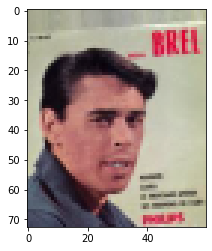

In [7]:
plt.imshow(np.transpose(vutils.make_grid(torch.Tensor(train_batch['images'][0]), padding=2,normalize=True).cpu(),(0,1,2)))

In [8]:
# Load functions
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout2d, MaxPool2d, BatchNorm2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

In [9]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")


def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

No GPU available.


In [10]:
height, width, channels = IMAGE_SHAPE

conv_out_channels =  16 # <-- Filters in your convolutional layer
kernel_size = 5       # <-- Kernel size
conv_stride = 1       # <-- Stride
conv_pad    = 0       # <-- Padding
 


conv1_h = int(height - kernel_size + 2 * conv_pad / conv_stride + 1)
conv1_w = int(width - kernel_size + 2 * conv_pad / conv_stride + 1)

# Keep track of features to output layer
features_cat_size = int(conv_out_channels * conv1_h * conv1_w)\

# <-- Number of features concatenated before output layer
  
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_1 = Conv2d(in_channels=channels,
                             out_channels=conv_out_channels,
                             kernel_size=kernel_size,
                             stride=conv_stride,
                             padding=conv_pad)

             
        self.l_out = Linear(in_features=features_cat_size,
                            out_features=NUM_CLASSES,
                            bias=False)
        
    def forward(self, x_img):
        features = []
        out = {}
        
        ## Convolutional layer ##
        # - Change dimensions to fit the convolutional layer 
        # - Apply Conv2d
        # - Use an activation function
        # - Change dimensions s.t. the features can be used in the final FFNN output layer
        
        # >> YOUR CODE HERE <<
        x_img = x_img.permute(0,3,1,2)
        features_img = relu(self.conv_1(x_img))
        
        features_img = features_img.view(-1, features_cat_size)

        ## Output layer where all features are in use ##
        
        out['out'] = self.l_out(features_img)
        return out

net = Net()
if use_cuda:
    net.cuda()
print(net)

Net(
  (conv_1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (l_out): Linear(in_features=61824, out_features=2, bias=False)
)


In [11]:
LEARNING_RATE = 0.001
criterion = nn.CrossEntropyLoss()          #<-- Your code here.   

# weight_decay is equal to L2 regularization
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

def accuracy(ys, ts):
    predictions = torch.max(ys, 1)[1]
    correct_prediction = torch.eq(predictions, ts)
    return torch.mean(correct_prediction.float())

In [12]:
_img_shape = tuple([batch_size] + list(IMAGE_SHAPE))

def randnorm(size):
    return np.random.normal(0, 1, size).astype('float32')

# dummy data
_x_image = get_variable(Variable(torch.from_numpy(randnorm(_img_shape))))

# test the forward pass
output = net(x_img=_x_image)
output['out'].shape

torch.Size([128, 2])

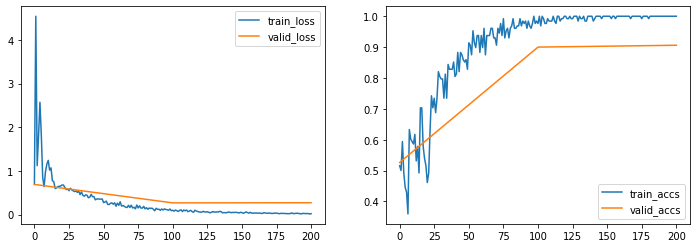

In [13]:
# Setup settings for training 
max_iter = 200
log_every = 100
eval_every = 100

# Function to get label
def get_labels(batch):
    return get_variable(Variable(torch.from_numpy(batch['ts']).long()))

# Function to get input
def get_input(batch):
    return {
        'x_img': get_variable(Variable(torch.from_numpy(batch['images'])))
    }

# Initialize lists for training and validation
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []

# Generate batches
batch_gen = data_utils_celeba.batch_generator(data,
                                       batch_size=batch_size,
                                       num_classes=NUM_CLASSES,
                                       num_iterations=max_iter,
                                       seed=42)

# Train network
net.train()
for i, batch_train in enumerate(batch_gen.gen_train()):
    if i % eval_every == 0:
        
        # Do the validaiton
        net.eval()
        val_losses, val_accs, val_lengths = 0, 0, 0
        for batch_valid, num in batch_gen.gen_valid():
            output = net(**get_input(batch_valid))
            labels_argmax = torch.max(get_labels(batch_valid), 1)[1]
            val_losses += criterion(output['out'], labels_argmax) * num
            val_accs += accuracy(output['out'], labels_argmax) * num
            val_lengths += num

        # Divide by the total accumulated batch sizes
        val_losses /= val_lengths
        val_accs /= val_lengths
        valid_loss.append(get_numpy(val_losses))
        valid_accs.append(get_numpy(val_accs))
        valid_iter.append(i)
#         print("Valid, it: {} loss: {:.2f} accs: {:.2f}\n".format(i, valid_loss[-1], valid_accs[-1]))
        net.train()
    
    # Train network
    output = net(**get_input(batch_train))
    labels_argmax = torch.max(get_labels(batch_train), 1)[1]
    batch_loss = criterion(output['out'], labels_argmax)
    
    train_iter.append(i)
    train_loss.append(float(get_numpy(batch_loss)))
    train_accs.append(float(get_numpy(accuracy(output['out'], labels_argmax))))
    
    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()
    
    # Log i figure
    if i % log_every == 0:
        fig = plt.figure(figsize=(12,4))
        plt.subplot(1, 2, 1)
        plt.plot(train_iter, train_loss, label='train_loss')
        plt.plot(valid_iter, valid_loss, label='valid_loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(train_iter, train_accs, label='train_accs')
        plt.plot(valid_iter, valid_accs, label='valid_accs')
        plt.legend()
        plt.show()
        clear_output(wait=True)
        #print("Train, it: {} loss: {:.2f} accs: {:.2f}".format(i, train_loss[-1], train_accs[-1]))
        
    if max_iter < i:
        break

In [14]:
print("Train, it: {} loss: {:.2f} accs: {:.2f}".format(i, train_loss[-1], train_accs[-1]))
print("Valid, it: {} loss: {:.2f} accs: {:.4f}".format(i, valid_loss[-1], valid_accs[-1]))

Train, it: 201 loss: 0.02 accs: 1.00
Valid, it: 201 loss: 0.27 accs: 0.9060


In [15]:
valid_accs

[array(0.526, dtype=float32),
 array(0.9, dtype=float32),
 array(0.906, dtype=float32)]

In [16]:
val_male_losses,val_male_accs,val_male_lengths,val_female_losses,val_female_accs,val_female_lengths = 0, 0, 0, 0, 0, 0

for batch_valid, num in batch_gen.gen_valid():
    output = net(**get_input(batch_valid))
    labels_argmax = torch.max(get_labels(batch_valid), 1)[1]
    
    gender = batch_valid['attributes'][:,19]
    male = np.where(gender==1)
    female = np.where(gender==-1)
    print(len(male[0])  + len(female[0]))

    val_male_losses += criterion(output['out'][male], labels_argmax[male]) * len(male[0]) 
    val_male_accs += accuracy(output['out'][male], labels_argmax[male]) * len(male[0]) 
    val_male_lengths += len(male[0])
    val_female_losses += criterion(output['out'][female], labels_argmax[female]) * len(female[0]) 
    val_female_accs += accuracy(output['out'][female], labels_argmax[female]) * len(female[0]) 
    val_female_lengths += len(female[0])    

# Divide by the total accumulated batch sizes
val_male_losses /= val_male_lengths
val_male_accs /= val_male_lengths

val_female_losses /= val_female_lengths
val_female_accs /= val_female_lengths

print("Valid Male, it: {} loss: {:.2f} accs: {:.4f}\n".format(i, val_male_losses, val_male_accs))
print("Valid Female, it: {} loss: {:.2f} accs: {:.4f}\n".format(i, val_female_losses, val_female_accs))

128
128
128
128
128
128
128
104
Valid Male, it: 201 loss: 0.18 accs: 0.9242

Valid Female, it: 201 loss: 0.36 accs: 0.8848



In [17]:
labels_argmax

tensor([1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,
        1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
        1, 0, 0, 1, 0, 0, 1, 1])

In [18]:
output

{'out': tensor([[-4.1338,  4.0847],
         [-3.8528,  3.8198],
         [ 1.9797, -2.0067],
         [-3.1810,  3.2253],
         [-1.7757,  1.8930],
         [ 2.0111, -1.9843],
         [ 0.1881, -0.2871],
         [ 1.2059, -1.1434],
         [ 2.7050, -2.7022],
         [-2.8623,  2.8688],
         [-0.5215,  0.5350],
         [ 5.2083, -5.3120],
         [ 1.3039, -1.2613],
         [ 1.7511, -1.8067],
         [ 5.0669, -5.1261],
         [-3.2448,  3.2883],
         [ 0.7368, -0.8013],
         [ 1.8245, -1.8409],
         [ 3.8823, -3.8426],
         [-4.8611,  4.9424],
         [-2.4761,  2.4796],
         [ 3.5315, -3.5591],
         [-7.5844,  7.5742],
         [-1.9485,  1.8773],
         [-3.6129,  3.5363],
         [ 2.7721, -2.7413],
         [ 2.3171, -2.2799],
         [-2.8957,  2.9329],
         [-1.0812,  1.0567],
         [ 0.1837, -0.2467],
         [ 4.7524, -4.7756],
         [ 0.0964, -0.1362],
         [ 2.8830, -2.8885],
         [ 3.0180, -3.0157],
       

In [19]:
criterion(output['out'][male], labels_argmax[male])

tensor(0.0962, grad_fn=<NllLossBackward>)

In [105]:
output['out'][[1,2,4]]

tensor([[-0.2603,  0.1588],
        [ 4.2025, -4.2215],
        [ 5.0927, -5.1272]], grad_fn=<IndexBackward>)

In [101]:
criterion(output['out'][1:2], labels_argmax[1:2])

tensor(0.5054, grad_fn=<NllLossBackward>)

In [87]:
batch_valid['attributes'][20]

array([-1., -1., -1., -1., -1., -1., -1., -1.,  1., -1., -1., -1.,  1.,
       -1., -1., -1., -1., -1., -1., -1.,  1., -1., -1., -1.,  1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,
        1.], dtype=float32)

In [70]:
labels_argmax

tensor([0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
        1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,
        0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 0, 1, 0, 0])

In [88]:
output['out'][1]

tensor([ 1.8560, -2.0070], grad_fn=<SelectBackward>)

In [201]:
list(matched.columns).index('Male')

20

In [115]:
output['out'][np.where(gender==1)]

tensor([[ 1.8826, -1.9732],
        [-1.8142,  1.6052],
        [-1.0776,  0.9112],
        [ 1.6518, -1.7931],
        [ 1.4825, -1.5211],
        [ 1.3251, -1.4765],
        [-1.3728,  1.2550]], grad_fn=<IndexBackward>)

In [187]:
batch_valid['attributes'][:,38]

array([ 1., -1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1., -1.,  1.,
        1., -1., -1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,
       -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.,  1.,
        1., -1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,
       -1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,
       -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,
        1., -1.,  1., -1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1., -1., -1.,  1.,  1.,  1.,  1., -1., -1., -1., -1.,  1.,  1.,
        1., -1.,  1.,  1., -1.,  1.,  1., -1., -1., -1.,  1.],
      dtype=float32)

In [185]:
batch_valid['attributes'].shape

(128, 40)